In [60]:
# If you ae new to go last cell

In [2]:
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedKFold,GridSearchCV
from sklearn.metrics import accuracy_score, classification_report,recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Training Data (CC undersampling)===Testing Data (CC undersampling)
train_df = pd.read_csv(".././Training-Testing Dataset/Training Data (RWS Oversampling).csv")
test_df = pd.read_csv(".././Training-Testing Dataset/Testing Data (Representative).csv")
# test_df = pd.read_csv(".././Training-Testing Dataset/Testing Data (CC undersampling).csv")

X_train = train_df.drop(columns=["target"])
Y_train = train_df["target"]
X_test = test_df.drop(columns=["target"])
Y_test = test_df["target"]


print(Y_train.value_counts())
print(Y_test.value_counts())


target
Medium_Yes    4492
Low_No        4492
Medium_No     4492
High_No       4492
Low_Yes       4492
High_Yes      4492
Name: count, dtype: int64
target
Medium_No     1123
High_No        672
Low_No         455
Medium_Yes     127
High_Yes        76
Low_Yes         47
Name: count, dtype: int64


In [7]:
categorical_features = [col for col in X_train.columns if X_train[col].dtype == 'object']

classes = np.unique(Y_train)
class_weights = compute_class_weight(class_weight="balanced", classes=classes,y=Y_train)
class_weights_dict = dict(zip(classes, class_weights))
for i,v in class_weights_dict.items():
    class_weights_dict[i] = int(v)

print(class_weights_dict)

for col in categorical_features:
    X_train[col] = X_train[col].astype('object')

    X_test[col] = X_test[col].astype('object')

# Y_train["target"] = Y_train["target"].astype(str)
# Y_test["target"] = Y_test["target"].astype(str)

train_pool = Pool(X_train,Y_train,cat_features=categorical_features)
test_pool = Pool(X_test,Y_test,cat_features=categorical_features)

{'High_No': 1, 'High_Yes': 1, 'Low_No': 1, 'Low_Yes': 1, 'Medium_No': 1, 'Medium_Yes': 1}


In [9]:
model = CatBoostClassifier(
    iterations=3000,
    depth=10,
    learning_rate=0.03,
    l2_leaf_reg=0.8,
    loss_function="MultiClass",
    eval_metric="MultiClass", 
    early_stopping_rounds=200,
    verbose=50,
    random_state=42,
)

In [ ]:
print("\nStarting CatBoost Training (Optimizing Weighted MultiClass Loss)...")
model.fit(train_pool,eval_set=test_pool)

y_pred_labels = model.predict(X_test).flatten()

# Evaluation: Still use scikit-learn for the final, explicit Macro Recall score
macro_recall = recall_score(Y_test, y_pred_labels, average='macro')
weighted_f1 = f1_score(Y_test, y_pred_labels, average='weighted')

print("\nClassification Report:")
print(classification_report(Y_test, y_pred_labels))

print(f"Best Iteration: {model.get_best_iteration()}")
print(f"Macro Recall Score (The Goal Metric): {macro_recall * 100:.2f}%")
print(f"Weighted F1 Score: {weighted_f1 * 100:.2f}%")


Starting CatBoost Training (Optimizing Weighted MultiClass Loss)...
0:	learn: 1.7760279	test: 1.7844565	best: 1.7844565 (0)	total: 716ms	remaining: 35m 46s
50:	learn: 1.4877519	test: 1.6429076	best: 1.6429076 (50)	total: 27.2s	remaining: 26m 10s
100:	learn: 1.3719372	test: 1.5795306	best: 1.5795306 (100)	total: 52.2s	remaining: 24m 58s
150:	learn: 1.3090584	test: 1.5449946	best: 1.5449946 (150)	total: 1m 15s	remaining: 23m 48s
200:	learn: 1.2658880	test: 1.5223729	best: 1.5223729 (200)	total: 1m 37s	remaining: 22m 33s
250:	learn: 1.2327710	test: 1.5062350	best: 1.5062350 (250)	total: 1m 58s	remaining: 21m 38s
300:	learn: 1.1725446	test: 1.4739991	best: 1.4739991 (300)	total: 2m 22s	remaining: 21m 14s
350:	learn: 1.0849284	test: 1.4205081	best: 1.4205081 (350)	total: 2m 48s	remaining: 21m 14s
400:	learn: 0.9581935	test: 1.3337836	best: 1.3337836 (400)	total: 3m 18s	remaining: 21m 28s
450:	learn: 0.8438771	test: 1.2436255	best: 1.2436255 (450)	total: 3m 48s	remaining: 21m 29s
500:	learn

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(Y_test)   # Now all labels become 0,1,2,3,4,5

np.bincount(y_encoded)
print("Test class counts:", np.bincount(y_encoded))
cm = confusion_matrix(Y_test, y_pred_labels)
print("Confusion matrix:\n", cm)
print("\nClass report:\n", classification_report(Y_test, y_pred_labels, digits=4))
# Medium_No     1123
# High_No        672
# Low_No         455
# Medium_Yes     127
# High_Yes        76
# Low_Yes         47

Test class counts: [ 672   76  455   47 1123  127]
Confusion matrix:
 [[446  22  61   9  92  42]
 [  0  71   3   0   0   2]
 [ 37  13 330  11  43  21]
 [  0   1   0  46   0   0]
 [150  44 107  22 747  53]
 [  2   1   1   0   2 121]]

Class report:
               precision    recall  f1-score   support

     High_No     0.7024    0.6637    0.6825       672
    High_Yes     0.4671    0.9342    0.6228        76
      Low_No     0.6574    0.7253    0.6897       455
     Low_Yes     0.5227    0.9787    0.6815        47
   Medium_No     0.8450    0.6652    0.7444      1123
  Medium_Yes     0.5063    0.9528    0.6612       127

    accuracy                         0.7044      2500
   macro avg     0.6168    0.8200    0.6803      2500
weighted avg     0.7378    0.7044    0.7087      2500



In [16]:
model.save_model(r"C:\Users\Administrator\OneDrive\Desktop\FYP-MODELS\catboost_marriage_model.cbm")

In [5]:
test_df_cc = pd.read_csv(".././Training-Testing Dataset/Testing data Undersampled(All).csv")

X_test_cc = train_df.drop(columns=["target"])
Y_test_cc = train_df["target"]


for col in categorical_features:
    X_test_cc[col] = X_test_cc[col].astype(str)

test_pool = Pool(X_test_cc,Y_test_cc,cat_features=categorical_features)

In [6]:
y_pred = model.predict(X_test_cc)

print("Accuracy rate ", accuracy_score(Y_test_cc,y_pred)*100)

Accuracy rate  44.925


In [7]:
test_df_cc = pd.read_csv(".././Training-Testing Dataset/Testing Data CC undersampling.csv")

X_test_cc = train_df.drop(columns=["target"])
Y_test_cc = train_df["target"]


for col in categorical_features:
    X_test_cc[col] = X_test_cc[col].astype(str)

test_pool = Pool(X_test_cc,Y_test_cc,cat_features=categorical_features)

y_pred = model.predict(X_test_cc)

print("Accuracy rate ", accuracy_score(Y_test_cc,y_pred)*100)

Accuracy rate  44.925


In [6]:
model = CatBoostClassifier()
model = model.load_model(r"D:\FinalYearProject\Matrimony_Matchmaker\notebooks\Model-CatBoost\catboost_marriage_model.cbm")
# test_df_cc = pd.read_csv(".././Training-Testing Dataset/Testing data Undersampled(All).csv")

# X_test_cc = test_df_cc.drop(columns=["target"])
# Y_test_cc = test_df_cc["target"]


# for col in categorical_features:
#     X_test_cc[col] = X_test_cc[col].astype(str)

# test_pool = Pool(X_test_cc,Y_test_cc,cat_features=categorical_features)

# y_pred = model.predict(X_test_cc)

# print("Accuracy rate ", accuracy_score(Y_test_cc,y_pred)*100)

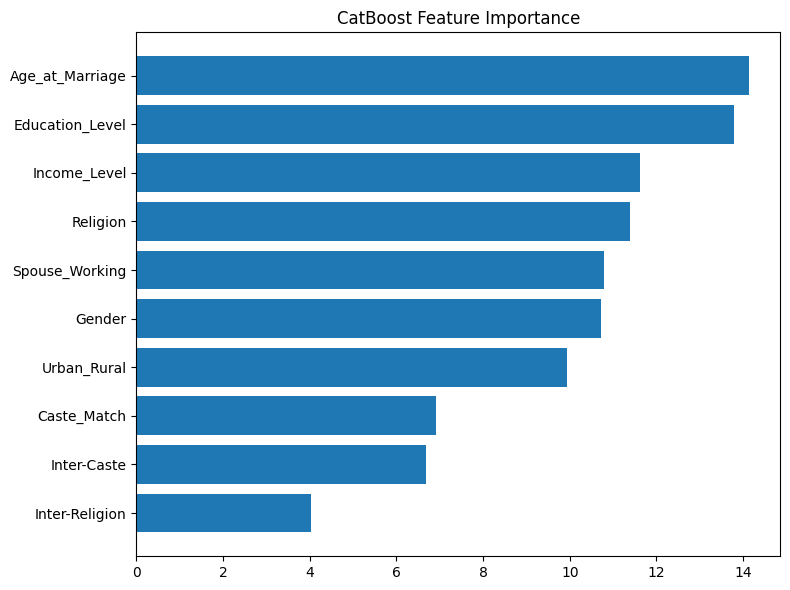

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Get importances
importances = model.get_feature_importance()
feature_names = model.feature_names_

# Sort
indices = np.argsort(importances)

# Plot
plt.figure(figsize=(8, 6))
plt.barh(range(len(importances)), importances[indices])
plt.yticks(range(len(importances)), np.array(feature_names)[indices])
plt.title("CatBoost Feature Importance")
plt.tight_layout()

# Save image
plt.savefig("catboost_importance.png", dpi=300, bbox_inches="tight")
plt.show()
